# 勾配ブースティング決定木のデモプログラム

勾配ブースティング決定木のデモプログラムです。  
勾配ブースティング決定木の中身に関してはこちら↓で解説しています。  
https://yuyumoyuyu.com/2021/02/21/ensembledecisiontree/

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.figure as figure
import numpy as np

from sklearn import model_selection, metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import time

%matplotlib inline

In [29]:
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.ensemble import GradientBoostingRegressor as GBR

from xgboost import XGBClassifier as XGBC
from xgboost import XGBRegressor as XGBR

from lightgbm import LGBMClassifier as LGBC
from lightgbm import LGBMRegressor as LGBR

import optuna

# クラス分類

In [3]:
from sklearn.datasets import load_iris

In [46]:
# Irisデータセットを用いる
iris = load_iris()

# 初期設定
fold_number = 3  # "k-分割交差検証の分割数
fraction_of_validation_samples = 0.2 # 検証に使うデータ割合

# 学習データをtrain/test分割
X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(iris.data,
                                                            iris.target,
                                                            random_state=0)

# スケーリング
scaler_c = StandardScaler()
X_train_i_scaled = scaler_c.fit_transform(X_train_i)
X_test_i_scaled = scaler_c.transform(X_test_i)

# 検証用
X_train_i_tmp, X_valid_i, y_train_i_tmp, y_valid_i = train_test_split(X_train_i_scaled,
                                                                      y_train_i,
                                                                      test_size=fraction_of_validation_samples,
                                                                      random_state=0)

In [47]:
# scikit-learnの勾配ブースティング
t1 = time.time()

gbc = GBC(n_estimators=1000, 
          validation_fraction=fraction_of_validation_samples,
          n_iter_no_change=100)
gbc.fit(X_train_i_scaled, y_train_i)
best_n_estimators_in_cv = len(gbc.estimators_)

def objective(trial):
    param = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1),
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 3, 20),
        'max_features': trial.suggest_loguniform('max_features', 0.1, 1.0)
    }

    gbc = GBC(**param, n_estimators=best_n_estimators_in_cv)
    estimated_y_in_cv = model_selection.cross_val_predict(gbc, X_train_i_scaled, y_train_i, cv=fold_number)
    acc = metrics.accuracy_score(y_train_i, estimated_y_in_cv)
    return 1.0 - acc

study = optuna.create_study()
study.optimize(objective, n_trials=100)

gbc = GBC(**study.best_params, 
          n_estimators=1000,
          validation_fraction=fraction_of_validation_samples, 
          n_iter_no_change=100)
gbc.fit(X_train_i_scaled, y_train_i)
best_n_estimators = len(gbc.estimators_)

gbc = GBC(**study.best_params, n_estimators=best_n_estimators)
gbc.fit(X_train_i_scaled, y_train_i)

# trainデータ
y_train_i_est = gbc.predict(X_train_i_scaled)

confusion_matrix_train = metrics.confusion_matrix(y_train_i, y_train_i_est, labels=sorted(set(y_train_i)))
print('training samples')
print(sorted(set(y_train_i)))
print(confusion_matrix_train)

# testデータ
y_test_i_pred = gbc.predict(X_test_i_scaled)

confusion_matrix_test = metrics.confusion_matrix(y_test_i, y_test_i_pred, labels=sorted(set(y_train_i)))
print('')
print('test samples')
print(sorted(set(y_train_i)))
print(confusion_matrix_test)

print("\nelapsed time: {:.3f} sec".format(time.time()-t1))

[I 2021-02-20 15:58:21,823] Finished trial#0 with value: 0.044642857142857095 with parameters: {'learning_rate': 0.7487926077832262, 'max_depth': 5, 'min_samples_leaf': 19, 'max_features': 0.8095832331864734}. Best is trial#0 with value: 0.044642857142857095.
[I 2021-02-20 15:58:22,341] Finished trial#1 with value: 0.044642857142857095 with parameters: {'learning_rate': 0.10954710527042945, 'max_depth': 7, 'min_samples_leaf': 6, 'max_features': 0.11721772123790797}. Best is trial#0 with value: 0.044642857142857095.
[I 2021-02-20 15:58:22,799] Finished trial#2 with value: 0.0357142857142857 with parameters: {'learning_rate': 0.12859401767245285, 'max_depth': 4, 'min_samples_leaf': 12, 'max_features': 0.11040587294576824}. Best is trial#2 with value: 0.0357142857142857.
[I 2021-02-20 15:58:23,205] Finished trial#3 with value: 0.0357142857142857 with parameters: {'learning_rate': 0.03268802889901401, 'max_depth': 5, 'min_samples_leaf': 17, 'max_features': 0.5465532716908863}. Best is tria

[I 2021-02-20 15:58:35,186] Finished trial#31 with value: 0.0267857142857143 with parameters: {'learning_rate': 0.17831248200850477, 'max_depth': 3, 'min_samples_leaf': 20, 'max_features': 0.48575581371214493}. Best is trial#10 with value: 0.0267857142857143.
[I 2021-02-20 15:58:35,590] Finished trial#32 with value: 0.0267857142857143 with parameters: {'learning_rate': 0.16674353262555944, 'max_depth': 4, 'min_samples_leaf': 20, 'max_features': 0.4728941501940203}. Best is trial#10 with value: 0.0267857142857143.
[I 2021-02-20 15:58:36,006] Finished trial#33 with value: 0.0267857142857143 with parameters: {'learning_rate': 0.1059482250280177, 'max_depth': 4, 'min_samples_leaf': 20, 'max_features': 0.4973508560646556}. Best is trial#10 with value: 0.0267857142857143.
[I 2021-02-20 15:58:36,422] Finished trial#34 with value: 0.0357142857142857 with parameters: {'learning_rate': 0.10404662270357229, 'max_depth': 6, 'min_samples_leaf': 20, 'max_features': 0.6650321752729079}. Best is trial

[I 2021-02-20 15:58:48,127] Finished trial#62 with value: 0.0267857142857143 with parameters: {'learning_rate': 0.05358717003525985, 'max_depth': 3, 'min_samples_leaf': 14, 'max_features': 0.15114802640425198}. Best is trial#10 with value: 0.0267857142857143.
[I 2021-02-20 15:58:48,534] Finished trial#63 with value: 0.0267857142857143 with parameters: {'learning_rate': 0.12251600061792804, 'max_depth': 2, 'min_samples_leaf': 18, 'max_features': 0.18040448090271216}. Best is trial#10 with value: 0.0267857142857143.
[I 2021-02-20 15:58:48,952] Finished trial#64 with value: 0.0357142857142857 with parameters: {'learning_rate': 0.031387141470567245, 'max_depth': 4, 'min_samples_leaf': 13, 'max_features': 0.10953315856439626}. Best is trial#10 with value: 0.0267857142857143.
[I 2021-02-20 15:58:49,382] Finished trial#65 with value: 0.0357142857142857 with parameters: {'learning_rate': 0.1393009032760027, 'max_depth': 5, 'min_samples_leaf': 19, 'max_features': 0.544205520456695}. Best is tri

[I 2021-02-20 15:59:01,060] Finished trial#93 with value: 0.0357142857142857 with parameters: {'learning_rate': 0.11328221992330768, 'max_depth': 2, 'min_samples_leaf': 14, 'max_features': 0.14842857819863492}. Best is trial#10 with value: 0.0267857142857143.
[I 2021-02-20 15:59:01,471] Finished trial#94 with value: 0.044642857142857095 with parameters: {'learning_rate': 0.05746910314411815, 'max_depth': 2, 'min_samples_leaf': 13, 'max_features': 0.1223529318648778}. Best is trial#10 with value: 0.0267857142857143.
[I 2021-02-20 15:59:01,887] Finished trial#95 with value: 0.0357142857142857 with parameters: {'learning_rate': 0.2649061128554553, 'max_depth': 3, 'min_samples_leaf': 16, 'max_features': 0.10419746922028665}. Best is trial#10 with value: 0.0267857142857143.
[I 2021-02-20 15:59:02,336] Finished trial#96 with value: 0.0357142857142857 with parameters: {'learning_rate': 0.3355422634015704, 'max_depth': 6, 'min_samples_leaf': 12, 'max_features': 0.2918693955427963}. Best is tri

training samples
[0, 1, 2]
[[37  0  0]
 [ 0 34  0]
 [ 0  0 41]]

test samples
[0, 1, 2]
[[13  0  0]
 [ 0 15  1]
 [ 0  0  9]]

elapsed time: 42.710 sec


In [52]:
# XGBoost
t1 = time.time()

xgbc = XGBC(n_estimators=1000)
xgbc.fit(X_train_i_tmp, 
         y_train_i_tmp,
         eval_set=[(X_valid_i, y_valid_i)],
         eval_metric='mlogloss', 
         early_stopping_rounds=100)
best_n_estimators_in_cv = xgbc.best_iteration

def objective(trial):
    param = {
        'verbosity': 0,
        'objective': 'reg:squarederror',
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
        'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0)
    }

    if param['booster'] == 'gbtree' or param['booster'] == 'dart':
        param['max_depth'] = trial.suggest_int('max_depth', 1, 9)
        param['eta'] = trial.suggest_loguniform('eta', 1e-8, 1.0)
        param['gamma'] = trial.suggest_loguniform('gamma', 1e-8, 1.0)
        param['grow_policy'] = trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide'])
    if param['booster'] == 'dart':
        param['sample_type'] = trial.suggest_categorical('sample_type', ['uniform', 'weighted'])
        param['normalize_type'] = trial.suggest_categorical('normalize_type', ['tree', 'forest'])
        param['rate_drop'] = trial.suggest_loguniform('rate_drop', 1e-8, 1.0)
        param['skip_drop'] = trial.suggest_loguniform('skip_drop', 1e-8, 1.0)

    xgbc = XGBC(**param, n_estimators=best_n_estimators_in_cv)
    estimated_y_in_cv = model_selection.cross_val_predict(xgbc, X_train_i_scaled, y_train_i, cv=fold_number)
    acc = metrics.accuracy_score(y_train_i, estimated_y_in_cv)
    return 1.0 - acc

study = optuna.create_study()
study.optimize(objective, n_trials=100)

xgbc = XGBC(**study.best_params, n_estimators=1000)
xgbc.fit(X_train_i_tmp, 
         y_train_i_tmp,
         eval_set=[(X_valid_i, y_valid_i.reshape([len(y_valid_i), 1]))],
         eval_metric='mlogloss', 
         early_stopping_rounds=100)
best_n_estimators = xgbc.best_iteration

xgbc = XGBC(**study.best_params, n_estimators=best_n_estimators)
xgbc.fit(X_train_i_scaled, y_train_i)

# trainデータ
y_train_i_est = gbc.predict(X_train_i_scaled)

confusion_matrix_train = metrics.confusion_matrix(y_train_i, y_train_i_est, labels=sorted(set(y_train_i)))
print('training samples')
print(sorted(set(y_train_i)))
print(confusion_matrix_train)

# testデータ
y_test_i_pred = gbc.predict(X_test_i_scaled)

confusion_matrix_test = metrics.confusion_matrix(y_test_i, y_test_i_pred, labels=sorted(set(y_train_i)))
print('')
print('test samples')
print(sorted(set(y_train_i)))
print(confusion_matrix_test)

print("\nelapsed time: {:.3f} sec".format(time.time()-t1))

[0]	validation_0-mlogloss:0.74534
Will train until validation_0-mlogloss hasn't improved in 100 rounds.
[1]	validation_0-mlogloss:0.53600
[2]	validation_0-mlogloss:0.40108
[3]	validation_0-mlogloss:0.31185
[4]	validation_0-mlogloss:0.24742
[5]	validation_0-mlogloss:0.20408
[6]	validation_0-mlogloss:0.17257
[7]	validation_0-mlogloss:0.15103
[8]	validation_0-mlogloss:0.13256
[9]	validation_0-mlogloss:0.12211
[10]	validation_0-mlogloss:0.11190
[11]	validation_0-mlogloss:0.11053
[12]	validation_0-mlogloss:0.11146
[13]	validation_0-mlogloss:0.10897
[14]	validation_0-mlogloss:0.10676
[15]	validation_0-mlogloss:0.10521
[16]	validation_0-mlogloss:0.10425
[17]	validation_0-mlogloss:0.10370
[18]	validation_0-mlogloss:0.10664
[19]	validation_0-mlogloss:0.10310
[20]	validation_0-mlogloss:0.10286
[21]	validation_0-mlogloss:0.10613
[22]	validation_0-mlogloss:0.10376
[23]	validation_0-mlogloss:0.10438
[24]	validation_0-mlogloss:0.10246
[25]	validation_0-mlogloss:0.10035
[26]	validation_0-mlogloss:0.1

[I 2021-02-20 16:06:02,182] Finished trial#0 with value: 0.0535714285714286 with parameters: {'booster': 'gbtree', 'lambda': 0.05222659835381107, 'alpha': 0.2720276454285522, 'max_depth': 7, 'eta': 0.009702274937348713, 'gamma': 1.9364946831440743e-06, 'grow_policy': 'depthwise'}. Best is trial#0 with value: 0.0535714285714286.
[I 2021-02-20 16:06:02,336] Finished trial#1 with value: 0.0625 with parameters: {'booster': 'gbtree', 'lambda': 5.097442212546301e-06, 'alpha': 0.1556153214352333, 'max_depth': 1, 'eta': 6.024724941054298e-05, 'gamma': 2.925454674925535e-07, 'grow_policy': 'lossguide'}. Best is trial#0 with value: 0.0535714285714286.
[I 2021-02-20 16:06:02,533] Finished trial#2 with value: 0.0535714285714286 with parameters: {'booster': 'gbtree', 'lambda': 2.9096678807297825e-07, 'alpha': 9.535578432968527e-08, 'max_depth': 9, 'eta': 0.00010497685394583088, 'gamma': 0.002667311010407451, 'grow_policy': 'depthwise'}. Best is trial#0 with value: 0.0535714285714286.
[I 2021-02-20 

[I 2021-02-20 16:06:06,398] Finished trial#24 with value: 0.0357142857142857 with parameters: {'booster': 'gbtree', 'lambda': 6.85264482398465e-07, 'alpha': 1.5032605193362232e-05, 'max_depth': 3, 'eta': 0.08481300463367114, 'gamma': 1.5371245797324135e-08, 'grow_policy': 'depthwise'}. Best is trial#10 with value: 0.0357142857142857.
[I 2021-02-20 16:06:06,581] Finished trial#25 with value: 0.0714285714285714 with parameters: {'booster': 'gbtree', 'lambda': 1.08511389132602e-06, 'alpha': 0.0035755841657468253, 'max_depth': 2, 'eta': 0.0025831225088282397, 'gamma': 0.002112104513269442, 'grow_policy': 'depthwise'}. Best is trial#10 with value: 0.0357142857142857.
[I 2021-02-20 16:06:06,747] Finished trial#26 with value: 0.0357142857142857 with parameters: {'booster': 'gbtree', 'lambda': 2.4075988543782215e-05, 'alpha': 1.1643087679910785e-05, 'max_depth': 4, 'eta': 0.9447410724950334, 'gamma': 0.008566786329925231, 'grow_policy': 'depthwise'}. Best is trial#10 with value: 0.035714285714

[I 2021-02-20 16:06:10,920] Finished trial#48 with value: 0.0535714285714286 with parameters: {'booster': 'gbtree', 'lambda': 2.578808049954642e-05, 'alpha': 1.873735106166354e-07, 'max_depth': 4, 'eta': 0.00018267043921923827, 'gamma': 1.482880382069549e-08, 'grow_policy': 'lossguide'}. Best is trial#10 with value: 0.0357142857142857.
[I 2021-02-20 16:06:11,137] Finished trial#49 with value: 0.0357142857142857 with parameters: {'booster': 'gbtree', 'lambda': 3.115277657355469e-06, 'alpha': 0.00013690945239639002, 'max_depth': 5, 'eta': 0.03828253545385281, 'gamma': 1.692136151153228e-08, 'grow_policy': 'depthwise'}. Best is trial#10 with value: 0.0357142857142857.
[I 2021-02-20 16:06:11,325] Finished trial#50 with value: 0.0357142857142857 with parameters: {'booster': 'dart', 'lambda': 0.0007854567561062946, 'alpha': 1.8246610004681907e-05, 'max_depth': 4, 'eta': 0.9577225170362886, 'gamma': 0.010417341772802225, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type':

[I 2021-02-20 16:06:15,046] Finished trial#69 with value: 0.0357142857142857 with parameters: {'booster': 'dart', 'lambda': 0.0004855916065909757, 'alpha': 1.2620062321385177e-05, 'max_depth': 4, 'eta': 0.06365948067080614, 'gamma': 0.026814385278720987, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 2.2136857433570088e-07, 'skip_drop': 4.927815863749542e-06}. Best is trial#10 with value: 0.0357142857142857.
[I 2021-02-20 16:06:15,250] Finished trial#70 with value: 0.0714285714285714 with parameters: {'booster': 'gbtree', 'lambda': 0.00018284140217146632, 'alpha': 0.08916761291148363, 'max_depth': 6, 'eta': 1.663158395534922e-05, 'gamma': 5.079514167895899e-07, 'grow_policy': 'depthwise'}. Best is trial#10 with value: 0.0357142857142857.
[I 2021-02-20 16:06:15,434] Finished trial#71 with value: 0.0357142857142857 with parameters: {'booster': 'dart', 'lambda': 4.95067007804547e-05, 'alpha': 4.093483219439382e-05, 'max_depth': 5, 'eta': 0.

[I 2021-02-20 16:06:19,275] Finished trial#91 with value: 0.0357142857142857 with parameters: {'booster': 'gbtree', 'lambda': 1.5579517256699339e-06, 'alpha': 0.008946932915313866, 'max_depth': 4, 'eta': 0.059758809454692, 'gamma': 1.0099171314690084e-07, 'grow_policy': 'depthwise'}. Best is trial#10 with value: 0.0357142857142857.
[I 2021-02-20 16:06:19,465] Finished trial#92 with value: 0.0357142857142857 with parameters: {'booster': 'gbtree', 'lambda': 0.0005266822561580307, 'alpha': 0.018770577731122756, 'max_depth': 4, 'eta': 0.0769879984284433, 'gamma': 1.0734608811628246e-07, 'grow_policy': 'depthwise'}. Best is trial#10 with value: 0.0357142857142857.
[I 2021-02-20 16:06:19,672] Finished trial#93 with value: 0.0357142857142857 with parameters: {'booster': 'dart', 'lambda': 3.7985921397651356e-05, 'alpha': 5.357967530747517e-08, 'max_depth': 7, 'eta': 0.13920090250827583, 'gamma': 0.00022067621321123084, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'f

[0]	validation_0-mlogloss:0.64164
Will train until validation_0-mlogloss hasn't improved in 100 rounds.
[1]	validation_0-mlogloss:0.42817
[2]	validation_0-mlogloss:0.31079
[3]	validation_0-mlogloss:0.23617
[4]	validation_0-mlogloss:0.18947
[5]	validation_0-mlogloss:0.16038
[6]	validation_0-mlogloss:0.14768
[7]	validation_0-mlogloss:0.13946
[8]	validation_0-mlogloss:0.13493
[9]	validation_0-mlogloss:0.13157
[10]	validation_0-mlogloss:0.12913
[11]	validation_0-mlogloss:0.12592
[12]	validation_0-mlogloss:0.12400
[13]	validation_0-mlogloss:0.12156
[14]	validation_0-mlogloss:0.12045
[15]	validation_0-mlogloss:0.11870
[16]	validation_0-mlogloss:0.11807
[17]	validation_0-mlogloss:0.11681
[18]	validation_0-mlogloss:0.11647
[19]	validation_0-mlogloss:0.11623
[20]	validation_0-mlogloss:0.11532
[21]	validation_0-mlogloss:0.11521
[22]	validation_0-mlogloss:0.11451
[23]	validation_0-mlogloss:0.11447
[24]	validation_0-mlogloss:0.11444
[25]	validation_0-mlogloss:0.11386
[26]	validation_0-mlogloss:0.1

In [54]:
# LightGBM
t1 = time.time()

lgbc = LGBC(n_estimators=1000)
lgbc.fit(X_train_i_tmp, 
         y_train_i_tmp,
         eval_set=(X_valid_i, y_valid_i),
         eval_metric='logloss', 
         early_stopping_rounds=100)
best_n_estimators_in_cv = lgbc.best_iteration_

def objective(trial):
    param = {
        'verbosity': -1,
        'boosting_type': trial.suggest_categorical('boosting', ['gbdt', 'dart', 'goss']),
        'num_leaves': trial.suggest_int('num_leaves', 10, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0)
    }

    if param['boosting_type'] == 'dart':
        param['drop_rate'] = trial.suggest_loguniform('drop_rate', 1e-8, 1.0)
        param['skip_drop'] = trial.suggest_loguniform('skip_drop', 1e-8, 1.0)
    if param['boosting_type'] == 'goss':
        param['top_rate'] = trial.suggest_uniform('top_rate', 0.0, 1.0)
        param['other_rate'] = trial.suggest_uniform('other_rate', 0.0, 1.0 - param['top_rate'])

    lgbc = LGBC(**param, n_estimators=best_n_estimators_in_cv)
    estimated_y_in_cv = model_selection.cross_val_predict(lgbc, X_train_i_scaled, y_train_i, cv=fold_number)
    acc = metrics.accuracy_score(y_train_i, estimated_y_in_cv)
    return 1.0 - acc

study = optuna.create_study()
study.optimize(objective, n_trials=100)

lgbc = LGBC(**study.best_params, n_estimators=1000)
lgbc.fit(X_train_i_tmp, 
         y_train_i_tmp,
         eval_set=(X_valid_i, y_valid_i),
         eval_metric='logloss', 
         early_stopping_rounds=100)
best_n_estimators_in_cv = lgbc.best_iteration_

lgbc = LGBC(**study.best_params, n_estimators=best_n_estimators)
lgbc.fit(X_train_i_scaled, y_train_i)

# trainデータ
y_train_i_est = gbc.predict(X_train_i_scaled)

confusion_matrix_train = metrics.confusion_matrix(y_train_i, y_train_i_est, labels=sorted(set(y_train_i)))
print('training samples')
print(sorted(set(y_train_i)))
print(confusion_matrix_train)

# testデータ
y_test_i_pred = gbc.predict(X_test_i_scaled)

confusion_matrix_test = metrics.confusion_matrix(y_test_i, y_test_i_pred, labels=sorted(set(y_train_i)))
print('')
print('test samples')
print(sorted(set(y_train_i)))
print(confusion_matrix_test)

print("\nelapsed time: {:.3f} sec".format(time.time()-t1))

[1]	valid_0's multi_logloss: 0.934623
Training until validation scores don't improve for 100 rounds
[2]	valid_0's multi_logloss: 0.801975
[3]	valid_0's multi_logloss: 0.697201
[4]	valid_0's multi_logloss: 0.611019
[5]	valid_0's multi_logloss: 0.538852
[6]	valid_0's multi_logloss: 0.478827
[7]	valid_0's multi_logloss: 0.427523
[8]	valid_0's multi_logloss: 0.382224
[9]	valid_0's multi_logloss: 0.345304
[10]	valid_0's multi_logloss: 0.315642
[11]	valid_0's multi_logloss: 0.292591
[12]	valid_0's multi_logloss: 0.269939
[13]	valid_0's multi_logloss: 0.250485
[14]	valid_0's multi_logloss: 0.233098
[15]	valid_0's multi_logloss: 0.218093
[16]	valid_0's multi_logloss: 0.20323
[17]	valid_0's multi_logloss: 0.192881
[18]	valid_0's multi_logloss: 0.184344
[19]	valid_0's multi_logloss: 0.177374
[20]	valid_0's multi_logloss: 0.171756
[21]	valid_0's multi_logloss: 0.165011
[22]	valid_0's multi_logloss: 0.161414
[23]	valid_0's multi_logloss: 0.156296
[24]	valid_0's multi_logloss: 0.154264
[25]	valid_0

[I 2021-02-20 16:08:15,727] Finished trial#0 with value: 0.6339285714285714 with parameters: {'boosting': 'gbdt', 'num_leaves': 989, 'learning_rate': 3.81621574084108e-05}. Best is trial#0 with value: 0.6339285714285714.
[I 2021-02-20 16:08:15,880] Finished trial#1 with value: 0.0892857142857143 with parameters: {'boosting': 'goss', 'num_leaves': 646, 'learning_rate': 0.030262637875471562, 'top_rate': 0.3825636317059129, 'other_rate': 0.608802893954836}. Best is trial#1 with value: 0.0892857142857143.
[I 2021-02-20 16:08:16,022] Finished trial#2 with value: 0.0714285714285714 with parameters: {'boosting': 'goss', 'num_leaves': 148, 'learning_rate': 0.019841877175785748, 'top_rate': 0.6475400500852023, 'other_rate': 0.27271205511385765}. Best is trial#2 with value: 0.0714285714285714.
[I 2021-02-20 16:08:16,163] Finished trial#3 with value: 0.4375 with parameters: {'boosting': 'dart', 'num_leaves': 312, 'learning_rate': 0.0005299392054097889, 'drop_rate': 0.0011291158100775402, 'skip_dr

[I 2021-02-20 16:08:20,835] Finished trial#34 with value: 0.0535714285714286 with parameters: {'boosting': 'gbdt', 'num_leaves': 312, 'learning_rate': 0.17456031046176404}. Best is trial#11 with value: 0.0357142857142857.
[I 2021-02-20 16:08:20,991] Finished trial#35 with value: 0.0625 with parameters: {'boosting': 'gbdt', 'num_leaves': 565, 'learning_rate': 0.008207366556830936}. Best is trial#11 with value: 0.0357142857142857.
[I 2021-02-20 16:08:21,135] Finished trial#36 with value: 0.044642857142857095 with parameters: {'boosting': 'dart', 'num_leaves': 177, 'learning_rate': 0.9950106125131196, 'drop_rate': 7.723338557209074e-07, 'skip_drop': 3.2140925899029024e-06}. Best is trial#11 with value: 0.0357142857142857.
[I 2021-02-20 16:08:21,275] Finished trial#37 with value: 0.044642857142857095 with parameters: {'boosting': 'dart', 'num_leaves': 164, 'learning_rate': 0.9546661272858559, 'drop_rate': 1.7197304249401651e-06, 'skip_drop': 8.011584202475473e-06}. Best is trial#11 with va

[I 2021-02-20 16:08:25,740] Finished trial#66 with value: 0.6339285714285714 with parameters: {'boosting': 'dart', 'num_leaves': 505, 'learning_rate': 0.00011070063058594902, 'drop_rate': 1.5344083922249356e-07, 'skip_drop': 0.000212575190146678}. Best is trial#11 with value: 0.0357142857142857.
[I 2021-02-20 16:08:25,896] Finished trial#67 with value: 0.0535714285714286 with parameters: {'boosting': 'dart', 'num_leaves': 196, 'learning_rate': 0.2637771874639268, 'drop_rate': 4.954811963205557e-07, 'skip_drop': 3.079021466318766e-06}. Best is trial#11 with value: 0.0357142857142857.
[I 2021-02-20 16:08:26,045] Finished trial#68 with value: 0.0535714285714286 with parameters: {'boosting': 'gbdt', 'num_leaves': 127, 'learning_rate': 0.5168627999201644}. Best is trial#11 with value: 0.0357142857142857.
[I 2021-02-20 16:08:26,201] Finished trial#69 with value: 0.1428571428571429 with parameters: {'boosting': 'gbdt', 'num_leaves': 537, 'learning_rate': 0.001516280469196334}. Best is trial#1

[I 2021-02-20 16:08:30,555] Finished trial#98 with value: 0.0535714285714286 with parameters: {'boosting': 'dart', 'num_leaves': 122, 'learning_rate': 0.2739028490877215, 'drop_rate': 1.647984097089263e-06, 'skip_drop': 1.4007083000008828e-05}. Best is trial#84 with value: 0.0267857142857143.
[I 2021-02-20 16:08:30,706] Finished trial#99 with value: 0.0625 with parameters: {'boosting': 'gbdt', 'num_leaves': 425, 'learning_rate': 0.06510630916664888}. Best is trial#84 with value: 0.0267857142857143.


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[1]	valid_0's multi_logloss: 0.229873
Training until validation scores don't improve for 100 rounds
[2]	valid_0's multi_logloss: 0.0999637
[3]	valid_0's multi_logloss: 0.0588271
[4]	valid_0's multi_logloss: 0.0855775
[5]	valid_0's multi_logloss: 0.0440447
[6]	valid_0's multi_logloss: 0.0295447
[7]	valid_0's multi_logloss: 0.040119
[8]	valid_0's multi_logloss: 0.0366175
[9]	valid_0's multi_logloss: 0.0451015
[10]	valid_0's multi_logloss: 0.0333597
[11]	valid_0's multi_logloss: 0.0297368
[12]	valid_0's multi_logloss: 0.0220706
[13]	valid_0's multi_logloss: 0.0380875
[14]	valid_0's multi_logloss: 0.0438341
[15]	valid_0's multi_logloss: 0.0282982
[16]	valid_0's multi_logloss: 0.0604017
[17]	valid_0's multi_logloss: 0.0621995
[18]	valid_0's multi_logloss: 0.0682172
[19]	valid_0's multi_logloss: 0.0618068
[20]	valid_0's multi_logloss: 0.063236
[21]	valid_0's multi_logloss: 0.0782889
[2

# 回帰木

In [5]:
from sklearn.datasets import load_boston

In [41]:
# Bostonデータセットを用いる
boston = load_boston()

# 初期設定
fold_number = 3  # "k-分割交差検証の分割数
fraction_of_validation_samples = 0.2 # 検証に使うデータ割合

# 学習データをtrain/test分割
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(boston.data,
                                                            boston.target,
                                                            random_state=0)

# スケーリング
scaler_r = StandardScaler()
X_train_b_scaled = scaler_r.fit_transform(X_train_b)
X_test_b_scaled = scaler_r.transform(X_test_b)

# 検証用
X_train_b_tmp, X_valid_b, y_train_b_tmp, y_valid_b = train_test_split(X_train_b_scaled,
                                                                      y_train_b,
                                                                      test_size=fraction_of_validation_samples,
                                                                      random_state=0)

[I 2021-02-20 15:06:02,018] Finished trial#0 with value: 0.14556936379857788 with parameters: {'learning_rate': 0.014022107361681278, 'max_depth': 5, 'min_samples_leaf': 18, 'max_features': 0.3202658325065346}. Best is trial#0 with value: 0.14556936379857788.
[I 2021-02-20 15:06:02,299] Finished trial#1 with value: 0.13031115562887385 with parameters: {'learning_rate': 0.39301481229318197, 'max_depth': 8, 'min_samples_leaf': 18, 'max_features': 0.15525871347029951}. Best is trial#1 with value: 0.13031115562887385.
[I 2021-02-20 15:06:02,508] Finished trial#2 with value: 0.15608147666596017 with parameters: {'learning_rate': 0.7289083194089389, 'max_depth': 1, 'min_samples_leaf': 7, 'max_features': 0.16470225825701387}. Best is trial#1 with value: 0.13031115562887385.
[I 2021-02-20 15:06:02,806] Finished trial#3 with value: 0.13890288407938378 with parameters: {'learning_rate': 0.18233512317599707, 'max_depth': 6, 'min_samples_leaf': 6, 'max_features': 0.16809831600189246}. Best is tria

[I 2021-02-20 15:06:13,805] Finished trial#31 with value: 0.11763653477507918 with parameters: {'learning_rate': 0.1973294359474548, 'max_depth': 5, 'min_samples_leaf': 8, 'max_features': 0.25236978512489655}. Best is trial#29 with value: 0.1026856868146151.
[I 2021-02-20 15:06:14,145] Finished trial#32 with value: 0.21442735422936743 with parameters: {'learning_rate': 0.6037614483132039, 'max_depth': 6, 'min_samples_leaf': 5, 'max_features': 0.2748661001307385}. Best is trial#29 with value: 0.1026856868146151.
[I 2021-02-20 15:06:14,489] Finished trial#33 with value: 0.12619528728309226 with parameters: {'learning_rate': 0.43527498874830584, 'max_depth': 5, 'min_samples_leaf': 10, 'max_features': 0.32615401481274475}. Best is trial#29 with value: 0.1026856868146151.
[I 2021-02-20 15:06:14,821] Finished trial#34 with value: 0.10886813612824486 with parameters: {'learning_rate': 0.10016886131055933, 'max_depth': 6, 'min_samples_leaf': 8, 'max_features': 0.28427945153872963}. Best is tri

[I 2021-02-20 15:06:23,645] Finished trial#62 with value: 0.10601243403964256 with parameters: {'learning_rate': 0.0923145524695969, 'max_depth': 8, 'min_samples_leaf': 9, 'max_features': 0.3168140594702764}. Best is trial#43 with value: 0.09798353879266997.
[I 2021-02-20 15:06:24,025] Finished trial#63 with value: 0.10237823639083332 with parameters: {'learning_rate': 0.08670966141302551, 'max_depth': 6, 'min_samples_leaf': 6, 'max_features': 0.3161195381249496}. Best is trial#43 with value: 0.09798353879266997.
[I 2021-02-20 15:06:24,332] Finished trial#64 with value: 0.11012118970817886 with parameters: {'learning_rate': 0.050775465428099964, 'max_depth': 6, 'min_samples_leaf': 6, 'max_features': 0.21947585902196398}. Best is trial#43 with value: 0.09798353879266997.
[I 2021-02-20 15:06:24,718] Finished trial#65 with value: 0.10580494939103913 with parameters: {'learning_rate': 0.08484787055972758, 'max_depth': 6, 'min_samples_leaf': 4, 'max_features': 0.3493819389911786}. Best is t

[I 2021-02-20 15:06:34,911] Finished trial#93 with value: 0.1080030534352856 with parameters: {'learning_rate': 0.08485254963153048, 'max_depth': 6, 'min_samples_leaf': 9, 'max_features': 0.39817872376679725}. Best is trial#43 with value: 0.09798353879266997.
[I 2021-02-20 15:06:35,230] Finished trial#94 with value: 0.11351873602327833 with parameters: {'learning_rate': 0.04523650340052056, 'max_depth': 5, 'min_samples_leaf': 8, 'max_features': 0.3036329042168601}. Best is trial#43 with value: 0.09798353879266997.
[I 2021-02-20 15:06:35,683] Finished trial#95 with value: 0.12005851676040091 with parameters: {'learning_rate': 0.1336438163564612, 'max_depth': 5, 'min_samples_leaf': 6, 'max_features': 0.5453724015766501}. Best is trial#43 with value: 0.09798353879266997.
[I 2021-02-20 15:06:35,947] Finished trial#96 with value: 0.13554007870888396 with parameters: {'learning_rate': 0.1080492417287538, 'max_depth': 7, 'min_samples_leaf': 8, 'max_features': 0.1492192465864518}. Best is tria

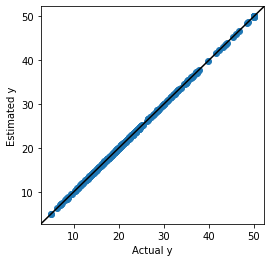

  Training set score: 0.122


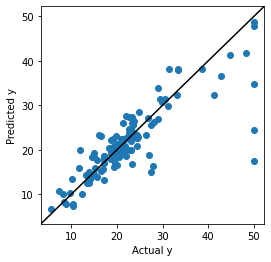

  Test set score: 0.039

elapsed time: 35.841 sec


In [27]:
# scikit-learnの勾配ブースティング
t1 = time.time()

gbr = GBR(n_estimators=1000, 
          validation_fraction=fraction_of_validation_samples,
          n_iter_no_change=100)
gbr.fit(X_train_b_scaled, y_train_b)
best_n_estimators_in_cv = len(gbr.estimators_)

def objective(trial):
    param = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1),
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 3, 20),
        'max_features': trial.suggest_loguniform('max_features', 0.1, 1.0)
    }

    gbr = GBR(**param, n_estimators=best_n_estimators_in_cv)
    estimated_y_in_cv = model_selection.cross_val_predict(gbr, X_train_b_scaled, y_train_b, cv=fold_number)
    r2 = metrics.r2_score(y_train_b, estimated_y_in_cv)
    return 1.0 - r2

study = optuna.create_study()
study.optimize(objective, n_trials=100)

gbr = GBR(**study.best_params, 
          n_estimators=1000,   
          validation_fraction=fraction_of_validation_samples, 
          n_iter_no_change=100)
gbr.fit(X_train_b_scaled, y_train_b)
best_n_estimators = len(gbr.estimators_)

gbr = GBR(**study.best_params, n_estimators=best_n_estimators)
gbr.fit(X_train_b_scaled, y_train_b)

# trainデータ
y_train_b_est = gbr.predict(X_train_b_scaled)

plt.figure(figsize=figure.figaspect(1))
plt.scatter(y_train_b, y_train_b_est)
y_max = max( y_train_b.max(), y_train_b_est.max() )
y_min = min( y_train_b.min(), y_train_b_est.min() )
plt.plot([y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)],
         [y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)], 'k-')
plt.ylim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))
plt.xlim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))
plt.xlabel('Actual y')
plt.ylabel('Estimated y')
plt.show()
print("  Training set score: {:.3f}".format(gbr.score(X_train_b_scaled, y_train_b))) 

# testデータ
y_test_b_pred = gbr.predict(X_test_b_scaled)

plt.figure(figsize=figure.figaspect(1))
plt.scatter(y_test_b, y_test_b_pred)
y_max = max( y_test_b.max(), y_test_b_pred.max() )
y_min = min( y_test_b.min(), y_test_b_pred.min() )
plt.plot([y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)],
         [y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)], 'k-')
plt.ylim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))
plt.xlim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.show()
print("  Test set score: {:.3f}".format(gbr.score(X_test_b_scaled, y_test_b)))

print("\nelapsed time: {:.3f} sec".format(time.time()-t1))

[0]	validation_0-rmse:17.26774
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:12.47189
[2]	validation_0-rmse:9.16644
[3]	validation_0-rmse:6.92748
[4]	validation_0-rmse:5.38133
[5]	validation_0-rmse:4.35916
[6]	validation_0-rmse:3.69381
[7]	validation_0-rmse:3.19673
[8]	validation_0-rmse:2.92373
[9]	validation_0-rmse:2.83281
[10]	validation_0-rmse:2.76399
[11]	validation_0-rmse:2.71567
[12]	validation_0-rmse:2.71866
[13]	validation_0-rmse:2.68229
[14]	validation_0-rmse:2.65255
[15]	validation_0-rmse:2.65374
[16]	validation_0-rmse:2.64153
[17]	validation_0-rmse:2.65025
[18]	validation_0-rmse:2.64452
[19]	validation_0-rmse:2.64279
[20]	validation_0-rmse:2.64077
[21]	validation_0-rmse:2.64693
[22]	validation_0-rmse:2.65421
[23]	validation_0-rmse:2.66308
[24]	validation_0-rmse:2.67009
[25]	validation_0-rmse:2.66448
[26]	validation_0-rmse:2.66359
[27]	validation_0-rmse:2.66759
[28]	validation_0-rmse:2.67461
[29]	validation_0-rmse:2.67894
[30]	validat

[I 2021-02-20 15:22:57,088] Finished trial#0 with value: 6.729716419768047 with parameters: {'booster': 'gbtree', 'lambda': 2.5205863536177752e-05, 'alpha': 0.0002471116527793863, 'max_depth': 5, 'eta': 1.2986555657256882e-07, 'gamma': 0.004264866303985402, 'grow_policy': 'lossguide'}. Best is trial#0 with value: 6.729716419768047.
[I 2021-02-20 15:22:57,193] Finished trial#1 with value: 148203067.509233 with parameters: {'booster': 'gblinear', 'lambda': 3.7437230421726366e-07, 'alpha': 0.00039165046805263377}. Best is trial#0 with value: 6.729716419768047.
[I 2021-02-20 15:22:57,317] Finished trial#2 with value: 6.7244189375745425 with parameters: {'booster': 'dart', 'lambda': 0.055870286063528826, 'alpha': 6.428950276823759e-07, 'max_depth': 6, 'eta': 2.033192279181235e-05, 'gamma': 0.0031207319680222074, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 9.045860462381953e-06, 'skip_drop': 0.261426645870647}. Best is trial#2 with value: 6

[I 2021-02-20 15:22:59,949] Finished trial#23 with value: 5.593125866469908 with parameters: {'booster': 'gbtree', 'lambda': 1.3866901084314243e-05, 'alpha': 0.0021414326646245255, 'max_depth': 2, 'eta': 0.004872283461271146, 'gamma': 8.642583982230353e-07, 'grow_policy': 'lossguide'}. Best is trial#21 with value: 0.16753625886731638.
[I 2021-02-20 15:23:00,069] Finished trial#24 with value: 0.15658114705628579 with parameters: {'booster': 'gbtree', 'lambda': 0.00013960371988460375, 'alpha': 0.04176982020095234, 'max_depth': 2, 'eta': 0.18195410747829308, 'gamma': 3.5508281600763805e-08, 'grow_policy': 'lossguide'}. Best is trial#24 with value: 0.15658114705628579.
[I 2021-02-20 15:23:00,188] Finished trial#25 with value: 0.27806253563719274 with parameters: {'booster': 'gbtree', 'lambda': 0.0001920869102108795, 'alpha': 0.13648286953008093, 'max_depth': 1, 'eta': 0.9601301028043948, 'gamma': 1.9206467242910755e-08, 'grow_policy': 'lossguide'}. Best is trial#24 with value: 0.1565811470

[I 2021-02-20 15:23:02,899] Finished trial#47 with value: 1075782.2485034957 with parameters: {'booster': 'gblinear', 'lambda': 0.00040603996994137317, 'alpha': 8.83143474057567e-08}. Best is trial#43 with value: 0.13822418771146916.
[I 2021-02-20 15:23:03,028] Finished trial#48 with value: 0.3888278908011681 with parameters: {'booster': 'gbtree', 'lambda': 0.003706928670825135, 'alpha': 5.924290627775385e-07, 'max_depth': 4, 'eta': 0.08410302504499258, 'gamma': 1.295450142666349e-08, 'grow_policy': 'depthwise'}. Best is trial#43 with value: 0.13822418771146916.
[I 2021-02-20 15:23:03,149] Finished trial#49 with value: 6.728401544586121 with parameters: {'booster': 'gbtree', 'lambda': 0.0003768184370430121, 'alpha': 5.5559939688326935e-06, 'max_depth': 1, 'eta': 5.485969908406939e-06, 'gamma': 0.001020385839165707, 'grow_policy': 'depthwise'}. Best is trial#43 with value: 0.13822418771146916.
[I 2021-02-20 15:23:03,271] Finished trial#50 with value: 2.8925828331638654 with parameters: 

[I 2021-02-20 15:23:05,940] Finished trial#71 with value: 0.17616709454562307 with parameters: {'booster': 'gbtree', 'lambda': 3.579325684682324e-05, 'alpha': 0.00025686668978814654, 'max_depth': 2, 'eta': 0.43982862348070234, 'gamma': 6.518932366496505e-08, 'grow_policy': 'lossguide'}. Best is trial#43 with value: 0.13822418771146916.
[I 2021-02-20 15:23:06,067] Finished trial#72 with value: 0.14674834578940243 with parameters: {'booster': 'gbtree', 'lambda': 2.6167473682097217e-05, 'alpha': 0.004360596263332565, 'max_depth': 3, 'eta': 0.3478536375857739, 'gamma': 3.8093186134159373e-08, 'grow_policy': 'lossguide'}. Best is trial#43 with value: 0.13822418771146916.
[I 2021-02-20 15:23:06,197] Finished trial#73 with value: 0.1740326884296235 with parameters: {'booster': 'gbtree', 'lambda': 6.104611459817108e-05, 'alpha': 0.0007002843472370216, 'max_depth': 4, 'eta': 0.18045679702960904, 'gamma': 1.776439817393873e-08, 'grow_policy': 'lossguide'}. Best is trial#43 with value: 0.13822418

[I 2021-02-20 15:23:08,961] Finished trial#95 with value: 0.15026293078084163 with parameters: {'booster': 'gbtree', 'lambda': 8.384103068122355e-07, 'alpha': 2.3325963642390424e-08, 'max_depth': 2, 'eta': 0.2316329076922229, 'gamma': 1.441660137802905e-07, 'grow_policy': 'depthwise'}. Best is trial#43 with value: 0.13822418771146916.
[I 2021-02-20 15:23:09,087] Finished trial#96 with value: 0.21006195774345027 with parameters: {'booster': 'gbtree', 'lambda': 9.843034148842579e-07, 'alpha': 1.925455670499027e-08, 'max_depth': 1, 'eta': 0.19379169602244595, 'gamma': 8.603338596542594e-07, 'grow_policy': 'depthwise'}. Best is trial#43 with value: 0.13822418771146916.
[I 2021-02-20 15:23:09,217] Finished trial#97 with value: 0.15434292346972334 with parameters: {'booster': 'gbtree', 'lambda': 6.91235901111674e-07, 'alpha': 1.212739749809286e-07, 'max_depth': 2, 'eta': 0.33891694520544513, 'gamma': 1.1184506306716906e-07, 'grow_policy': 'depthwise'}. Best is trial#43 with value: 0.13822418

[0]	validation_0-rmse:16.24949
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:11.42102
[2]	validation_0-rmse:8.06543
[3]	validation_0-rmse:5.95646
[4]	validation_0-rmse:4.59248
[5]	validation_0-rmse:3.70403
[6]	validation_0-rmse:3.31586
[7]	validation_0-rmse:3.13617
[8]	validation_0-rmse:3.04102
[9]	validation_0-rmse:3.02606
[10]	validation_0-rmse:2.99367
[11]	validation_0-rmse:2.95135
[12]	validation_0-rmse:2.91170
[13]	validation_0-rmse:2.91267
[14]	validation_0-rmse:2.88691
[15]	validation_0-rmse:2.83011
[16]	validation_0-rmse:2.84112
[17]	validation_0-rmse:2.83158
[18]	validation_0-rmse:2.81630
[19]	validation_0-rmse:2.80320
[20]	validation_0-rmse:2.79373
[21]	validation_0-rmse:2.79643
[22]	validation_0-rmse:2.75148
[23]	validation_0-rmse:2.74930
[24]	validation_0-rmse:2.71692
[25]	validation_0-rmse:2.68466
[26]	validation_0-rmse:2.68067
[27]	validation_0-rmse:2.67601
[28]	validation_0-rmse:2.64427
[29]	validation_0-rmse:2.64477
[30]	validat

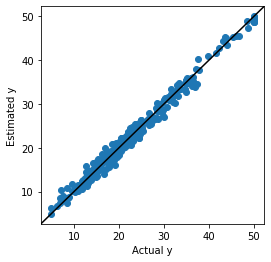

  Training set score: 0.987


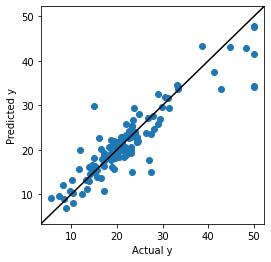

  Test set score: 0.819

elapsed time: 13.244 sec


In [37]:
# XGBoost
t1 = time.time()

xgbr = XGBR(n_estimators=1000)
xgbr.fit(X_train_b_tmp, 
         y_train_b_tmp,
         eval_set=[(X_valid_b, y_valid_b.reshape([len(y_valid_b), 1]))],
         eval_metric='rmse', 
         early_stopping_rounds=100)
best_n_estimators_in_cv = xgbr.best_iteration

def objective(trial):
    param = {
        'verbosity': 0,
        'objective': 'reg:squarederror',
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
        'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0)
    }

    if param['booster'] == 'gbtree' or param['booster'] == 'dart':
        param['max_depth'] = trial.suggest_int('max_depth', 1, 9)
        param['eta'] = trial.suggest_loguniform('eta', 1e-8, 1.0)
        param['gamma'] = trial.suggest_loguniform('gamma', 1e-8, 1.0)
        param['grow_policy'] = trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide'])
    if param['booster'] == 'dart':
        param['sample_type'] = trial.suggest_categorical('sample_type', ['uniform', 'weighted'])
        param['normalize_type'] = trial.suggest_categorical('normalize_type', ['tree', 'forest'])
        param['rate_drop'] = trial.suggest_loguniform('rate_drop', 1e-8, 1.0)
        param['skip_drop'] = trial.suggest_loguniform('skip_drop', 1e-8, 1.0)

    xgbr = XGBR(**param, n_estimators=best_n_estimators_in_cv)
    estimated_y_in_cv = model_selection.cross_val_predict(xgbr, X_train_b_scaled, y_train_b, cv=fold_number)
    r2 = metrics.r2_score(y_train_b, estimated_y_in_cv)
    return 1.0 - r2

study = optuna.create_study()
study.optimize(objective, n_trials=100)

xgbr = XGBR(**study.best_params, n_estimators=1000)
xgbr.fit(X_train_b_tmp, 
         y_train_b_tmp,
         eval_set=[(X_valid_b, y_valid_b.reshape([len(y_valid_b), 1]))],
         eval_metric='rmse', 
         early_stopping_rounds=100)
best_n_estimators = xgbr.best_iteration

xgbr = XGBR(**study.best_params, n_estimators=best_n_estimators)
xgbr.fit(X_train_b_scaled, y_train_b)

# trainデータ
y_train_b_est = xgbr.predict(X_train_b_scaled)

plt.figure(figsize=figure.figaspect(1))
plt.scatter(y_train_b, y_train_b_est)
y_max = max( y_train_b.max(), y_train_b_est.max() )
y_min = min( y_train_b.min(), y_train_b_est.min() )
plt.plot([y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)],
         [y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)], 'k-')
plt.ylim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))
plt.xlim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))
plt.xlabel('Actual y')
plt.ylabel('Estimated y')
plt.show()
print("  Training set score: {:.3f}".format(xgbr.score(X_train_b_scaled, y_train_b))) 

# testデータ
y_test_b_pred = xgbr.predict(X_test_b_scaled)

plt.figure(figsize=figure.figaspect(1))
plt.scatter(y_test_b, y_test_b_pred)
y_max = max( y_test_b.max(), y_test_b_pred.max() )
y_min = min( y_test_b.min(), y_test_b_pred.min() )
plt.plot([y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)],
         [y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)], 'k-')
plt.ylim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))
plt.xlim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.show()
print("  Test set score: {:.3f}".format(xgbr.score(X_test_b_scaled, y_test_b)))

print("\nelapsed time: {:.3f} sec".format(time.time()-t1))

[1]	valid_0's l2: 67.362
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l2: 58.2517
[3]	valid_0's l2: 50.9975
[4]	valid_0's l2: 45.9801
[5]	valid_0's l2: 40.9809
[6]	valid_0's l2: 36.2384
[7]	valid_0's l2: 32.7899
[8]	valid_0's l2: 29.6214
[9]	valid_0's l2: 26.6235
[10]	valid_0's l2: 24.2799
[11]	valid_0's l2: 22.3392
[12]	valid_0's l2: 20.7663
[13]	valid_0's l2: 19.412
[14]	valid_0's l2: 18.2903
[15]	valid_0's l2: 17.5059
[16]	valid_0's l2: 16.6898
[17]	valid_0's l2: 15.9321
[18]	valid_0's l2: 15.5448
[19]	valid_0's l2: 15.1073
[20]	valid_0's l2: 14.6569
[21]	valid_0's l2: 14.2591
[22]	valid_0's l2: 14.1035
[23]	valid_0's l2: 13.9002
[24]	valid_0's l2: 13.678
[25]	valid_0's l2: 13.5519
[26]	valid_0's l2: 13.2881
[27]	valid_0's l2: 13.0882
[28]	valid_0's l2: 12.9826
[29]	valid_0's l2: 12.8911
[30]	valid_0's l2: 12.7868
[31]	valid_0's l2: 12.7179
[32]	valid_0's l2: 12.6734
[33]	valid_0's l2: 12.5753
[34]	valid_0's l2: 12.5092
[35]	valid_0's l2: 12.4763
[36]	

[296]	valid_0's l2: 9.21737
[297]	valid_0's l2: 9.22509
[298]	valid_0's l2: 9.2382
[299]	valid_0's l2: 9.2393
[300]	valid_0's l2: 9.2337
[301]	valid_0's l2: 9.23641
[302]	valid_0's l2: 9.23263
[303]	valid_0's l2: 9.2202
[304]	valid_0's l2: 9.22057
[305]	valid_0's l2: 9.23054
[306]	valid_0's l2: 9.23842
[307]	valid_0's l2: 9.23678
[308]	valid_0's l2: 9.24168
[309]	valid_0's l2: 9.22809
[310]	valid_0's l2: 9.21617
[311]	valid_0's l2: 9.21403
[312]	valid_0's l2: 9.22014
[313]	valid_0's l2: 9.21122
[314]	valid_0's l2: 9.22653
[315]	valid_0's l2: 9.22473
[316]	valid_0's l2: 9.22811
[317]	valid_0's l2: 9.24537
[318]	valid_0's l2: 9.24543
[319]	valid_0's l2: 9.24891
[320]	valid_0's l2: 9.24433
[321]	valid_0's l2: 9.23687
[322]	valid_0's l2: 9.24223
[323]	valid_0's l2: 9.23736
[324]	valid_0's l2: 9.2358
[325]	valid_0's l2: 9.23108
[326]	valid_0's l2: 9.2388
[327]	valid_0's l2: 9.24251
[328]	valid_0's l2: 9.24388
[329]	valid_0's l2: 9.26408
[330]	valid_0's l2: 9.26953
[331]	valid_0's l2: 9.2647

[I 2021-02-20 15:26:02,141] Finished trial#0 with value: 1.004586400327506 with parameters: {'boosting': 'dart', 'num_leaves': 637, 'learning_rate': 9.012317976917039e-07, 'drop_rate': 2.448690658004995e-06, 'skip_drop': 4.185301801185221e-08}. Best is trial#0 with value: 1.004586400327506.
[I 2021-02-20 15:26:02,505] Finished trial#1 with value: 1.0045947891786489 with parameters: {'boosting': 'dart', 'num_leaves': 451, 'learning_rate': 8.866383470198281e-07, 'drop_rate': 2.084443735270908e-06, 'skip_drop': 9.784402903695103e-08}. Best is trial#0 with value: 1.004586400327506.
[I 2021-02-20 15:26:02,862] Finished trial#2 with value: 1.0041548783662244 with parameters: {'boosting': 'gbdt', 'num_leaves': 380, 'learning_rate': 1.6353299826999882e-06}. Best is trial#2 with value: 1.0041548783662244.
[I 2021-02-20 15:26:03,196] Finished trial#3 with value: 1.0050908467648354 with parameters: {'boosting': 'gbdt', 'num_leaves': 358, 'learning_rate': 2.3743140546154524e-08}. Best is trial#2 w

[I 2021-02-20 15:26:14,007] Finished trial#29 with value: 0.9859664840804429 with parameters: {'boosting': 'goss', 'num_leaves': 563, 'learning_rate': 3.337616293820838e-05, 'top_rate': 0.79797146870758, 'other_rate': 0.030589894802920937}. Best is trial#24 with value: 0.13264214338178792.
[I 2021-02-20 15:26:14,416] Finished trial#30 with value: 0.17089550119417818 with parameters: {'boosting': 'goss', 'num_leaves': 772, 'learning_rate': 0.00979843191335347, 'top_rate': 0.4039050051075951, 'other_rate': 0.3274681748252485}. Best is trial#24 with value: 0.13264214338178792.
[I 2021-02-20 15:26:14,856] Finished trial#31 with value: 0.1359173044150226 with parameters: {'boosting': 'goss', 'num_leaves': 720, 'learning_rate': 0.11653669990028273, 'top_rate': 0.13883651685237514, 'other_rate': 0.854838133613417}. Best is trial#24 with value: 0.13264214338178792.
[I 2021-02-20 15:26:15,241] Finished trial#32 with value: 0.13581838017514636 with parameters: {'boosting': 'goss', 'num_leaves': 

[I 2021-02-20 15:26:27,860] Finished trial#57 with value: 0.17554076650137063 with parameters: {'boosting': 'dart', 'num_leaves': 471, 'learning_rate': 0.011095046995953473, 'drop_rate': 0.018257242346662827, 'skip_drop': 0.8293062612836886}. Best is trial#41 with value: 0.12553950700629735.
[I 2021-02-20 15:26:28,267] Finished trial#58 with value: 0.15603207720935341 with parameters: {'boosting': 'dart', 'num_leaves': 518, 'learning_rate': 0.028837845973422375, 'drop_rate': 0.0026316864156081775, 'skip_drop': 4.6917212178760345e-05}. Best is trial#41 with value: 0.12553950700629735.
[I 2021-02-20 15:26:29,799] Finished trial#59 with value: 0.19736609293289264 with parameters: {'boosting': 'dart', 'num_leaves': 397, 'learning_rate': 0.2500328228531465, 'drop_rate': 0.16797324484157786, 'skip_drop': 0.07885834511291649}. Best is trial#41 with value: 0.12553950700629735.
[I 2021-02-20 15:26:30,123] Finished trial#60 with value: 1.0050991192493364 with parameters: {'boosting': 'dart', 'nu

[I 2021-02-20 15:26:42,971] Finished trial#85 with value: 1.23461241257531 with parameters: {'boosting': 'dart', 'num_leaves': 675, 'learning_rate': 0.22056197115861995, 'drop_rate': 0.3033562602785597, 'skip_drop': 0.0011103194532906498}. Best is trial#41 with value: 0.12553950700629735.
[I 2021-02-20 15:26:43,591] Finished trial#86 with value: 0.6026547345927794 with parameters: {'boosting': 'dart', 'num_leaves': 505, 'learning_rate': 0.072922812423436, 'drop_rate': 0.029734955489943263, 'skip_drop': 0.023868632521188305}. Best is trial#41 with value: 0.12553950700629735.
[I 2021-02-20 15:26:43,906] Finished trial#87 with value: 0.14484605429203634 with parameters: {'boosting': 'gbdt', 'num_leaves': 144, 'learning_rate': 0.4395752240045089}. Best is trial#41 with value: 0.12553950700629735.
[I 2021-02-20 15:26:44,370] Finished trial#88 with value: 0.14601811608623083 with parameters: {'boosting': 'dart', 'num_leaves': 740, 'learning_rate': 0.1344625549821791, 'drop_rate': 0.009716091

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
[1]	valid_0's l2: 59.4075


C:\Users\shimi\anaconda3\envs\mds\lib\site-packages\lightgbm\callback.py:186: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[2]	valid_0's l2: 46.2076
[3]	valid_0's l2: 37.2312
[4]	valid_0's l2: 30.9435
[5]	valid_0's l2: 25.9206
[6]	valid_0's l2: 22.1918
[7]	valid_0's l2: 19.7143
[8]	valid_0's l2: 17.8895
[9]	valid_0's l2: 16.1251
[10]	valid_0's l2: 15.0783
[11]	valid_0's l2: 14.5065
[12]	valid_0's l2: 13.9962
[13]	valid_0's l2: 13.7427
[14]	valid_0's l2: 13.4655
[15]	valid_0's l2: 13.1804
[16]	valid_0's l2: 13.0213
[17]	valid_0's l2: 12.7497
[18]	valid_0's l2: 12.8842
[19]	valid_0's l2: 12.8946
[20]	valid_0's l2: 12.8628
[21]	valid_0's l2: 12.8005
[22]	valid_0's l2: 12.7231
[23]	valid_0's l2: 12.7488
[24]	valid_0's l2: 12.6023
[25]	valid_0's l2: 12.546
[26]	valid_0's l2: 12.4746
[27]	valid_0's l2: 12.2688
[28]	valid_0's l2: 12.0953
[29]	valid_0's l2: 12.0769
[30]	valid_0's l2: 11.8984
[31]	valid_0's l2: 11.7271
[32]	valid_0's l2: 11.8657
[33]	valid_0's l2: 11.6872
[34]	valid_0's l2: 11.7726
[35]	valid_0's l2: 11.7419
[36]	valid_0's l2: 11.6717
[37]	valid_0's l2: 11.4508
[38]	valid_0's l2: 11.4192
[39]	valid

[299]	valid_0's l2: 9.03342
[300]	valid_0's l2: 9.03236
[301]	valid_0's l2: 9.04365
[302]	valid_0's l2: 9.0259
[303]	valid_0's l2: 9.0296
[304]	valid_0's l2: 9.03328
[305]	valid_0's l2: 9.04386
[306]	valid_0's l2: 9.03836
[307]	valid_0's l2: 9.05194
[308]	valid_0's l2: 9.05376
[309]	valid_0's l2: 8.88324
[310]	valid_0's l2: 8.91673
[311]	valid_0's l2: 8.45444
[312]	valid_0's l2: 8.49299
[313]	valid_0's l2: 8.57257
[314]	valid_0's l2: 8.64507
[315]	valid_0's l2: 8.69856
[316]	valid_0's l2: 8.77984
[317]	valid_0's l2: 8.84432
[318]	valid_0's l2: 8.82469
[319]	valid_0's l2: 8.87968
[320]	valid_0's l2: 8.91032
[321]	valid_0's l2: 8.89197
[322]	valid_0's l2: 8.90289
[323]	valid_0's l2: 8.90218
[324]	valid_0's l2: 8.92853
[325]	valid_0's l2: 8.93124
[326]	valid_0's l2: 8.95744
[327]	valid_0's l2: 8.98009
[328]	valid_0's l2: 8.98814
[329]	valid_0's l2: 9.02271
[330]	valid_0's l2: 9.01868
[331]	valid_0's l2: 9.02756
[332]	valid_0's l2: 9.03323
[333]	valid_0's l2: 9.02842
[334]	valid_0's l2: 9.

[592]	valid_0's l2: 8.67596
[593]	valid_0's l2: 8.68065
[594]	valid_0's l2: 8.67772
[595]	valid_0's l2: 8.67588
[596]	valid_0's l2: 8.67527
[597]	valid_0's l2: 8.66978
[598]	valid_0's l2: 8.6724
[599]	valid_0's l2: 8.67123
[600]	valid_0's l2: 8.66559
[601]	valid_0's l2: 8.65192
[602]	valid_0's l2: 8.65196
[603]	valid_0's l2: 8.35148
[604]	valid_0's l2: 8.37926
[605]	valid_0's l2: 8.39983
[606]	valid_0's l2: 8.44001
[607]	valid_0's l2: 8.43794
[608]	valid_0's l2: 8.47814
[609]	valid_0's l2: 8.50383
[610]	valid_0's l2: 8.52126
[611]	valid_0's l2: 8.51828
[612]	valid_0's l2: 8.51853
[613]	valid_0's l2: 8.48469
[614]	valid_0's l2: 8.48891
[615]	valid_0's l2: 8.49648
[616]	valid_0's l2: 8.54087
[617]	valid_0's l2: 8.54606
[618]	valid_0's l2: 8.55524
[619]	valid_0's l2: 8.5856
[620]	valid_0's l2: 8.58863
[621]	valid_0's l2: 8.59544
[622]	valid_0's l2: 8.58313
[623]	valid_0's l2: 8.61335
[624]	valid_0's l2: 8.61257
[625]	valid_0's l2: 8.61344
[626]	valid_0's l2: 8.59629
[627]	valid_0's l2: 8.

[885]	valid_0's l2: 8.30694
[886]	valid_0's l2: 8.31216
[887]	valid_0's l2: 8.32606
[888]	valid_0's l2: 8.34009
[889]	valid_0's l2: 8.34454
[890]	valid_0's l2: 8.34478
[891]	valid_0's l2: 8.34704
[892]	valid_0's l2: 8.35117
[893]	valid_0's l2: 8.35657
[894]	valid_0's l2: 8.34829
[895]	valid_0's l2: 8.34674
[896]	valid_0's l2: 8.30364
[897]	valid_0's l2: 8.29669
[898]	valid_0's l2: 8.30551
[899]	valid_0's l2: 8.2966
[900]	valid_0's l2: 8.29962
[901]	valid_0's l2: 8.25846
[902]	valid_0's l2: 8.26335
[903]	valid_0's l2: 8.27527
[904]	valid_0's l2: 8.27109
[905]	valid_0's l2: 8.26323
[906]	valid_0's l2: 8.272
[907]	valid_0's l2: 8.26368
[908]	valid_0's l2: 8.27389
[909]	valid_0's l2: 8.28349
[910]	valid_0's l2: 8.2849
[911]	valid_0's l2: 8.27539
[912]	valid_0's l2: 8.27887
[913]	valid_0's l2: 8.18748
[914]	valid_0's l2: 8.18253
[915]	valid_0's l2: 8.16994
[916]	valid_0's l2: 8.20162
[917]	valid_0's l2: 8.20148
[918]	valid_0's l2: 8.23919
[919]	valid_0's l2: 8.25961
[920]	valid_0's l2: 8.26

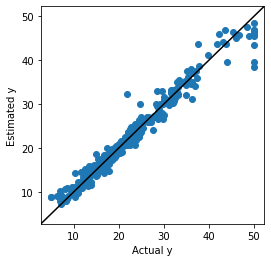

  Training set score: 0.965


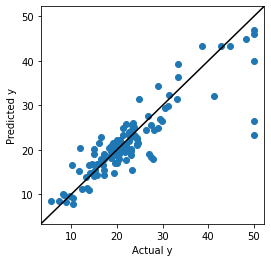

  Test set score: 0.754

elapsed time: 50.702 sec


In [40]:
# LightGBM
t1 = time.time()

lgbr = LGBR(n_estimators=1000)
lgbr.fit(X_train_b_tmp, 
         y_train_b_tmp,
         eval_set=(X_valid_b, y_valid_b),
         eval_metric='l2', 
         early_stopping_rounds=100)
best_n_estimators_in_cv = lgbr.best_iteration_

def objective(trial):
    param = {
        'verbosity': -1,
        'boosting_type': trial.suggest_categorical('boosting', ['gbdt', 'dart', 'goss']),
        'num_leaves': trial.suggest_int('num_leaves', 10, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0)
    }

    if param['boosting_type'] == 'dart':
        param['drop_rate'] = trial.suggest_loguniform('drop_rate', 1e-8, 1.0)
        param['skip_drop'] = trial.suggest_loguniform('skip_drop', 1e-8, 1.0)
    if param['boosting_type'] == 'goss':
        param['top_rate'] = trial.suggest_uniform('top_rate', 0.0, 1.0)
        param['other_rate'] = trial.suggest_uniform('other_rate', 0.0, 1.0 - param['top_rate'])

    lgbr = LGBR(**param, n_estimators=best_n_estimators_in_cv)
    estimated_y_in_cv = model_selection.cross_val_predict(lgbr, X_train_b_scaled, y_train_b, cv=fold_number)
    r2 = metrics.r2_score(y_train_b, estimated_y_in_cv)
    return 1.0 - r2

study = optuna.create_study()
study.optimize(objective, n_trials=100)

lgbr = LGBR(**study.best_params, n_estimators=1000)
lgbr.fit(X_train_b_tmp, 
         y_train_b_tmp,
         eval_set=(X_valid_b, y_valid_b),
         eval_metric='l2', 
         early_stopping_rounds=100)
best_n_estimators_in_cv = lgbr.best_iteration_

lgbr = LGBR(**study.best_params, n_estimators=best_n_estimators)
lgbr.fit(X_train_b_scaled, y_train_b)

# trainデータ
y_train_b_est = lgbr.predict(X_train_b_scaled)

plt.figure(figsize=figure.figaspect(1))
plt.scatter(y_train_b, y_train_b_est)
y_max = max( y_train_b.max(), y_train_b_est.max() )
y_min = min( y_train_b.min(), y_train_b_est.min() )
plt.plot([y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)],
         [y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)], 'k-')
plt.ylim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))
plt.xlim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))
plt.xlabel('Actual y')
plt.ylabel('Estimated y')
plt.show()
print("  Training set score: {:.3f}".format(lgbr.score(X_train_b_scaled, y_train_b))) 

# testデータ
y_test_b_pred = lgbr.predict(X_test_b_scaled)

plt.figure(figsize=figure.figaspect(1))
plt.scatter(y_test_b, y_test_b_pred)
y_max = max( y_test_b.max(), y_test_b_pred.max() )
y_min = min( y_test_b.min(), y_test_b_pred.min() )
plt.plot([y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)],
         [y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)], 'k-')
plt.ylim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))
plt.xlim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.show()
print("  Test set score: {:.3f}".format(lgbr.score(X_test_b_scaled, y_test_b)))

print("\nelapsed time: {:.3f} sec".format(time.time()-t1))